In [1]:
import unittest
from mrftools import *
import numpy as np
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import cv2

In [2]:
# noise level 20 %
np.log(4)/2 

0.6931471805599453

In [3]:
############################# Load Image #############################################

# Load the image
img = cv2.imread('images/cameraman.jpg')
resized_img = cv2.resize(img, (256, 256))

# Convert to grayscale
gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_, binary_img = cv2.threshold(gray_img, 127, 1, cv2.THRESH_BINARY)

cv2.imwrite('binary_image.png', binary_img*255)
binary_img.shape


### Add noise
def add_noise(img, flip_prob):
    ''' Adds noise to a given binary image. Value of each pixel is flipped with given probability
    # ARGUMENTS
    # =========
    # img (numpy array): image to which noise is to be added
    # flip_prob (float \in [0,1]): probability with which each pixel value is flipped
    '''
    img_noisy = np.copy(img)
    for i in range(img_noisy.shape[0]):
        for j in range(img_noisy.shape[1]):
            if np.random.rand() <= flip_prob:
                img_noisy[i][j] = 1 - img[i][j]
    return img_noisy


img_noise = add_noise(binary_img, flip_prob = 0.2)
cv2.imwrite('img_noise.png', img_noise *255)
x = binary_img.flatten()

#################### Generate planar graph of size nxn #######################################################################
n = img_noise.shape[0]
grid_size = n**2
y = img_noise.flatten()

h = 0.7
J = 0.35
k = 2 #alphabet size

mn = MarkovNet()

for i in range(grid_size):
    mn.set_unary_factor(i, h * np.array( [y[i], 1-y[i]] ))
    #mn.set_unary_factor(i, np.random.rand(k) )

#print(mn.variables)
#print( mn.unary_potentials )


for i in range(grid_size):
    for j in range(grid_size):
        if  j-i ==1 and j%n !=0 :
            #print(i,j)
            #u = np.random.uniform(0, 1, 1)[0]
            u = J
            mn.set_edge_factor((i, j), np.array([[ np.exp(u) , np.exp(-u)], [np.exp(-u), np.exp(u)]]) )
        if j-i == n:
            #print(i,j)
            #u = np.random.uniform(0, 1, 1)[0]
            u = J
            mn.set_edge_factor((i, j), np.array([[ np.exp(u) , np.exp(-u)], [np.exp(-u), np.exp(u)]]) )

#print(mn.variables)
print(mn.get_neighbors(145) )


####################### Assign Edge probabilities ###########################################################
edge_probabilities = dict()

for edge in mn.edge_potentials:
    #edge_probabilities[edge] = np.random.uniform(0,1,1)[0]
    #edge_probabilities[edge] = 2/grid_size # in complete graph
    edge_probabilities[edge] = (n+1)/(2*n)  # for planar graph


{144, 401, 146}


In [4]:
b = []
tt = np.linspace(0, 1, 21)
#tt = np.array([0.3])
for t in tt:

  for key, value in edge_probabilities.items():
      edge_probabilities[key] = value + t * (1-value)

  #print(t)
  trbp = MatrixTRBeliefPropagator(mn, edge_probabilities)
  trbp.infer(display='off')
  trbp.load_beliefs() 
  z_trw = trbp.compute_energy_functional()
  #print("z_trw:\t", z_trw)
  #print( np.exp(trbp.var_beliefs[0]) ) 

  for var in mn.variables:
      unary_belief = np.exp(trbp.var_beliefs[var])
      if unary_belief[0] > unary_belief[1]:
            y[var] = 1.0
      else:
            y[var] = 0.0

  print("Error FTRW \t", t , 1- (np.sum(x ==y)/ grid_size) )
  b.append(1- (np.sum(x ==y)/ grid_size))
  a = np.reshape(y, (n,n))
  cv2.imwrite(f'cameraFTRW{t}.png', a * 255)


Error FTRW 	 0.0 0.0646514892578125
Error FTRW 	 0.05 0.064544677734375
Error FTRW 	 0.1 0.0640411376953125
Error FTRW 	 0.15000000000000002 0.06414794921875
Error FTRW 	 0.2 0.0646820068359375
Error FTRW 	 0.25 0.065185546875
Error FTRW 	 0.30000000000000004 0.0658721923828125
Error FTRW 	 0.35000000000000003 0.0664215087890625
Error FTRW 	 0.4 0.0667877197265625
Error FTRW 	 0.45 0.0671539306640625
Error FTRW 	 0.5 0.067352294921875
Error FTRW 	 0.55 0.067291259765625
Error FTRW 	 0.6000000000000001 0.067352294921875
Error FTRW 	 0.65 0.0673675537109375
Error FTRW 	 0.7000000000000001 0.0673828125
Error FTRW 	 0.75 0.0673828125
Error FTRW 	 0.8 0.0673828125
Error FTRW 	 0.8500000000000001 0.0673828125
Error FTRW 	 0.9 0.0673828125
Error FTRW 	 0.9500000000000001 0.0673828125
Error FTRW 	 1.0 0.0673828125


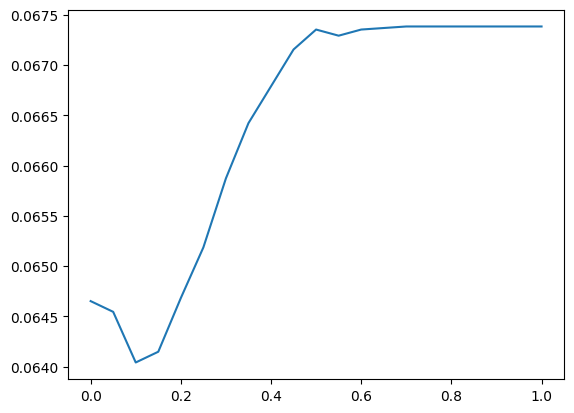

In [9]:
plt.plot(tt,b)
plt.savefig('a.pdf')
#plt.ylim(0.2, 0.5)

In [10]:
np.savetxt("j35.txt", np.array(b))

In [7]:
#j10 = np.loadtxt('j10.txt')
#j15 = np.loadtxt('j15.txt')
#j20 = np.loadtxt('j20.txt')
#j25 = np.loadtxt('j25.txt')
#j30 = np.loadtxt('j30.txt')
#j35 = np.loadtxt('j35.txt')
#j40 = np.loadtxt('j40.txt')
#j45 = np.loadtxt('j45.txt')
#j50 = np.loadtxt('j50.txt')

In [8]:
#plt.plot(tt, j10, label='J=0.10')
#plt.plot(tt, j15, label='J=0.15')
#plt.plot(tt, j20, label='J=0.20')
#plt.plot(tt, j25, label='J=0.25')
#plt.plot(tt, j30, label='J=0.30')
#plt.plot(tt, j35, label='J=0.35')
#plt.plot(tt, j40, label='J=0.40')
#plt.plot(tt, j45, label='J=0.45')
#plt.plot(tt, j50, label='J=0.50')

#plt.legend()
#plt.show()
